# Cats versus dogs
- We are working with smaller dataset

# 1- Import Libraries

### Packages required:
- tensorflow==2.18.0
- tensorflow-datasets==4.9.7
- matplotlib==3.10.1
- pandas==2.2.3
- opencv-python==4.11.0.86
- scikit-learn==1.6.1
- jupyter==1.1.1

In [87]:
import os
import numpy as np
import pandas as pd
import random as rnd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.layers import Flatten, Dense, Dropout
from keras.layers import Conv2D, MaxPool2D, BatchNormalization, Activation

from tensorflow.keras.preprocessing.image import ImageDataGenerator


# 2- Data-Constants

In [88]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_CHANNELS=3
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)

# 3- Load DataSet

In [89]:
# import zipfile

# path = "/kaggle/input/dogs-vs-cats"
# for zip_file in os.listdir(path)[:2]:
#     zipfile.ZipFile(f"{path}/{zip_file}", 'r').extractall(".")
# #     print(f"{path}/{zip_file}")
#     print(f"{zip_file} unzipped")

# 4- Data Preprocessing

> ## Label Encoding

In [105]:
# train_images = os.listdir("/kaggle/working/train")
images_path = "temp/data_cats_dogs_small"

images_cats_path = images_path + "/cats"
images_cats = os.listdir(images_cats_path)

CATEGORIES = []

for image_name in images_cats:
    class_name = image_name.split('.')[0]  # cat.588.jpg
    CATEGORIES.append(0 if class_name=='cat' else 1)

df_cats = pd.DataFrame({"images": images_cats, "category": CATEGORIES})
print(df_cats)

           images  category
0    cat.4001.jpg         0
1    cat.4002.jpg         0
2    cat.4003.jpg         0
3    cat.4004.jpg         0
4    cat.4005.jpg         0
..            ...       ...
495  cat.4496.jpg         0
496  cat.4497.jpg         0
497  cat.4498.jpg         0
498  cat.4499.jpg         0
499  cat.4500.jpg         0

[500 rows x 2 columns]


In [106]:
images_dogs_path = images_path + "/dogs"
images_dogs = os.listdir(images_dogs_path)

CATEGORIES = []

for image_name in images_dogs:
    class_name = image_name.split('.')[0]  # dog.588.jpg
    CATEGORIES.append(0 if class_name=='cat' else 1)

df_dogs = pd.DataFrame({"images": images_dogs, "category": CATEGORIES})
print(df_dogs)

           images  category
0    dog.4001.jpg         1
1    dog.4002.jpg         1
2    dog.4003.jpg         1
3    dog.4004.jpg         1
4    dog.4005.jpg         1
..            ...       ...
495  dog.4496.jpg         1
496  dog.4497.jpg         1
497  dog.4498.jpg         1
498  dog.4499.jpg         1
499  dog.4500.jpg         1

[500 rows x 2 columns]


> ## Show DataFrame

         images  category
0  cat.4001.jpg         0
1  cat.4002.jpg         0
2  cat.4003.jpg         0
3  cat.4004.jpg         0
4  cat.4005.jpg         0
%%%%%%%%%%%%%%%%%%%%%%%%%%
           images  category
495  dog.4496.jpg         1
496  dog.4497.jpg         1
497  dog.4498.jpg         1
498  dog.4499.jpg         1
499  dog.4500.jpg         1
^^^^^^^^^^^^^^^^^^^^^^^
         category
count  1000.00000
mean      0.50000
std       0.50025
min       0.00000
25%       0.00000
50%       0.50000
75%       1.00000
max       1.00000
&&&&&&&&&&&&&&&&&&&&&
category
0    500
1    500
Name: count, dtype: int64
**************************


<Axes: xlabel='category'>

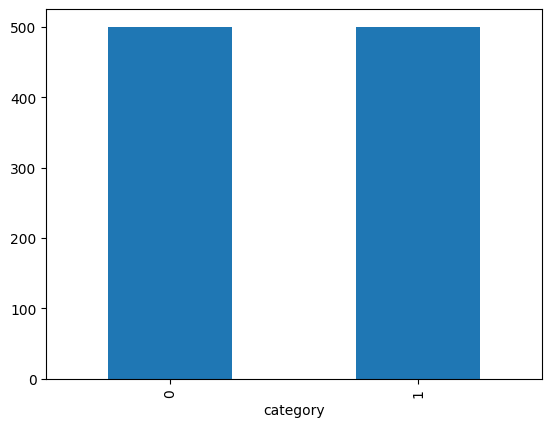

In [92]:
df= pd.concat([df_cats, df_dogs])
print(df.head())

print("%%%%%%%%%%%%%%%%%%%%%%%%%%")
print(df.tail())

print("^^^^^^^^^^^^^^^^^^^^^^^")
print(df.describe())

print("&&&&&&&&&&&&&&&&&&&&&")
print(df["category"].value_counts())

print("**************************")
# Visualize The Data
df["category"].value_counts().plot.bar() # cat should be balanced

> ## *From our data we have 500 cats and 500 dogs*

> ## Show Dimensions Of Images

In [93]:
# Lets see the dimensions of all the images. (image_width,image_height, channels)
shapes = []

for image in df_cats["images"]: # TODO change train_images -> images
    # path = os.path.join("/kaggle/working/train",image)
    path = os.path.join(images_cats_path,image)
    image_array = plt.imread(path)
    shapes.append(image_array.shape)

for image in df_dogs["images"]: # TODO change train_images -> images
    # path = os.path.join("/kaggle/working/train",image)
    path = os.path.join(images_dogs_path,image)
    image_array = plt.imread(path)
    shapes.append(image_array.shape)

    
print(pd.Series(shapes).value_counts())

(375, 499, 3)    122
(374, 500, 3)    122
(333, 499, 3)     15
(499, 375, 3)     10
(332, 500, 3)     10
                ... 
(279, 481, 3)      1
(499, 347, 3)      1
(407, 500, 3)      1
(499, 414, 3)      1
(158, 250, 3)      1
Name: count, Length: 623, dtype: int64


> ## **See sample image**


<class 'PIL.JpegImagePlugin.JpegImageFile'>


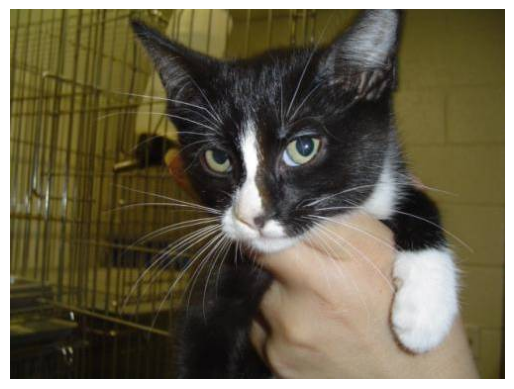

In [94]:
sample = rnd.choice(images_cats)
image = load_img(os.path.join(images_cats_path, sample))
print(type(image))
plt.imshow(image)
plt.axis("off")
plt.show()

<class 'PIL.JpegImagePlugin.JpegImageFile'>


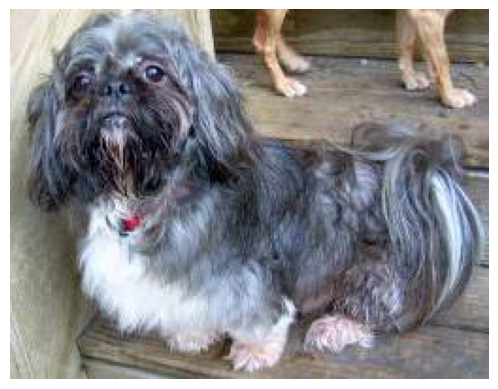

In [96]:
sample = rnd.choice(images_dogs)
image = load_img(os.path.join(images_dogs_path, sample))
print(type(image))
plt.imshow(image)
plt.axis("off")
plt.show()

> # Prepare data
> Because we will use image genaretor with class_mode="categorical". We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification.
> So we will convert 1 to dog and 0 to cat

In [97]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

> # Split Data

In [98]:
# perform stratified train-test split on a DataFrame, which means it's dividing the data while maintaining the same 
# proportion of classes in both the training and validation sets.
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, valid_idx in split.split(df, df['category']):  
    train_df = df.iloc[train_idx].reset_index(drop=True)
    valid_df = df.iloc[valid_idx].reset_index(drop=True)

print("Training:",train_df['category'].value_counts())
print("************************************")
print("Validation:", valid_df['category'].value_counts())


Training: category
dog    400
cat    400
Name: count, dtype: int64
************************************
Validation: category
dog    100
cat    100
Name: count, dtype: int64


> # Show train DataFrame

In [99]:
train_df['category'].value_counts()

category
dog    400
cat    400
Name: count, dtype: int64

<Axes: xlabel='category'>

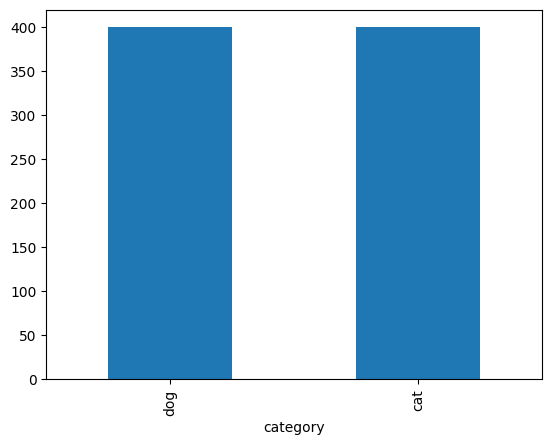

In [100]:
train_df['category'].value_counts().plot.bar()

> # Show valid DataFrame

In [101]:
valid_df['category'].value_counts()

category
dog    100
cat    100
Name: count, dtype: int64

<Axes: xlabel='category'>

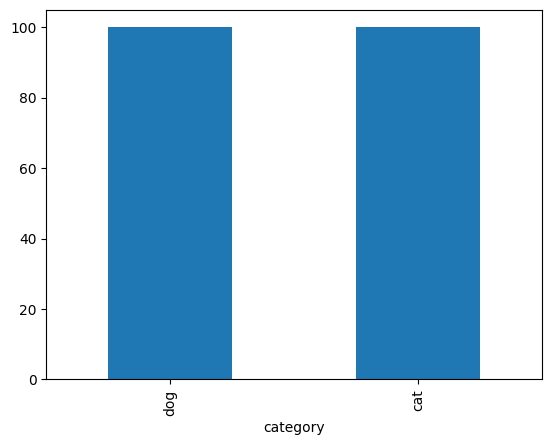

In [102]:
valid_df['category'].value_counts().plot.bar()

> # Data Augmentation

In [103]:
total_train = train_df.shape[0]
total_validate = valid_df.shape[0]
batch_size=15

> ## Train Generator

In [104]:
print(df.head(5))
print("**************")
print(df.tail(5))      

         images category
0  cat.4001.jpg      cat
1  cat.4002.jpg      cat
2  cat.4003.jpg      cat
3  cat.4004.jpg      cat
4  cat.4005.jpg      cat
**************
           images category
495  dog.4496.jpg      dog
496  dog.4497.jpg      dog
497  dog.4498.jpg      dog
498  dog.4499.jpg      dog
499  dog.4500.jpg      dog


In [107]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=(0.8, 1.5),        
    width_shift_range=0.1,        
    height_shift_range=0.1,       
    brightness_range=(0.5, 1.5),  
    horizontal_flip=True
)

# Add correct relative paths based on category
train_df['image_path'] = train_df.apply(lambda row: f"cats/{row['images']}" if row['category'] == 'cat' else f"dogs/{row['images']}", axis=1)
print(f"train_df:\n{train_df}")

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    directory=images_path,  # Assuming both 'cats' and 'dogs' are inside this directory
    x_col='image_path',  # Should contain paths like 'cat_sets/image1.jpg' and 'dog_sets/image2.jpg'
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

train_df:
           images category         image_path
0    dog.4360.jpg      dog  dogs/dog.4360.jpg
1    cat.4300.jpg      cat  cats/cat.4300.jpg
2    dog.4260.jpg      dog  dogs/dog.4260.jpg
3    cat.4398.jpg      cat  cats/cat.4398.jpg
4    dog.4295.jpg      dog  dogs/dog.4295.jpg
..            ...      ...                ...
795  cat.4140.jpg      cat  cats/cat.4140.jpg
796  dog.4457.jpg      dog  dogs/dog.4457.jpg
797  dog.4144.jpg      dog  dogs/dog.4144.jpg
798  cat.4238.jpg      cat  cats/cat.4238.jpg
799  dog.4238.jpg      dog  dogs/dog.4238.jpg

[800 rows x 3 columns]
Found 800 validated image filenames belonging to 2 classes.


> # Valid Generator

In [109]:
valid_datagen = ImageDataGenerator(rescale=1./255)

# Add correct relative paths based on category
valid_df['image_path'] = valid_df.apply(lambda row: f"cats/{row['images']}" if row['category'] == 'cat' else f"dogs/{row['images']}", axis=1)
print(f"valid_df:\n{valid_df}")

valid_generator = valid_datagen.flow_from_dataframe(
    valid_df, 
    directory=images_path,  # Assuming both 'cat_sets' and 'dog_sets' are inside this directory
    x_col='image_path',  # Should contain paths like 'cat_sets/image1.jpg' and 'dog_sets/image2.jpg'
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

valid_df:
           images category         image_path
0    dog.4408.jpg      dog  dogs/dog.4408.jpg
1    cat.4294.jpg      cat  cats/cat.4294.jpg
2    cat.4218.jpg      cat  cats/cat.4218.jpg
3    cat.4055.jpg      cat  cats/cat.4055.jpg
4    dog.4115.jpg      dog  dogs/dog.4115.jpg
..            ...      ...                ...
195  dog.4337.jpg      dog  dogs/dog.4337.jpg
196  dog.4013.jpg      dog  dogs/dog.4013.jpg
197  cat.4344.jpg      cat  cats/cat.4344.jpg
198  dog.4095.jpg      dog  dogs/dog.4095.jpg
199  dog.4253.jpg      dog  dogs/dog.4253.jpg

[200 rows x 3 columns]
Found 200 validated image filenames belonging to 2 classes.


> # See how our generator work

           images category         image_path
781  dog.4259.jpg      dog  dogs/dog.4259.jpg 

         images category         image_path
0  dog.4259.jpg      dog  dogs/dog.4259.jpg 

Found 1 validated image filenames belonging to 1 classes.
##########################


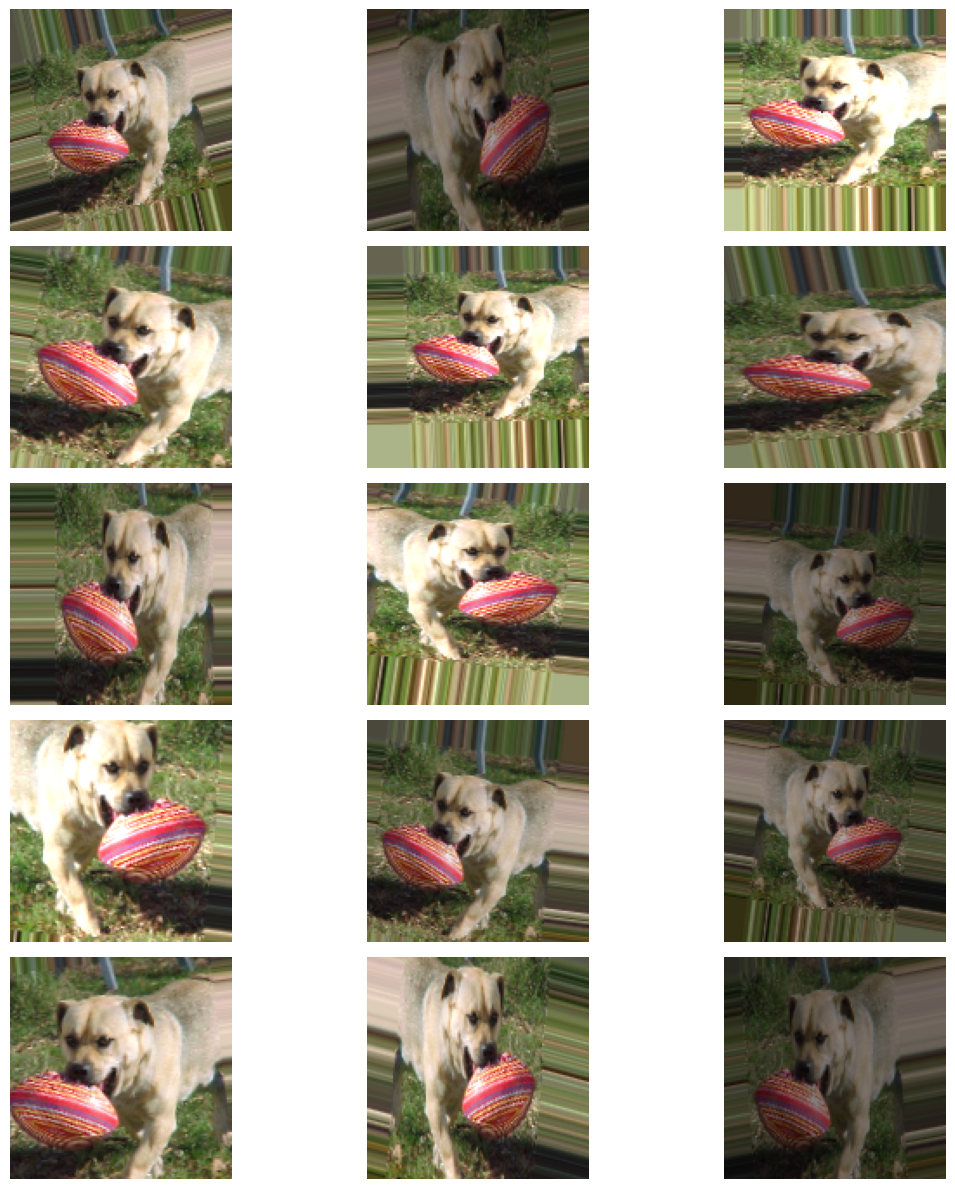

In [110]:
example_df = train_df.sample(n=1) # take 1 image-sample
print(example_df, "\n")

example_df= example_df.reset_index(drop=True)
print(example_df, "\n")

example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    directory=images_path,  # Assuming both 'cats' and 'dogs' are inside this directory
    x_col='image_path',  # Should contain paths like 'cats/image1.jpg' and 'dogs/image2.jpg'
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

print("##########################")
# Show Generated Images from One-Image
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        plt.axis('off')
        break
plt.tight_layout()
plt.show()


# 5- Build The Model

![image](https://i.imgur.com/ebkMGGu.jpg)

> * **Input Layer**: It represent input image data. It will reshape image into single diminsion array. Example your image is 64x64 = 4096, it will convert to (4096,1) array.
> * **Conv Layer**: This layer will extract features from image.
> * **Pooling Layer**: This layerreduce the spatial volume of input image after convolution.
> * **Fully Connected Layer**: It connect the network from a layer to another layer
> * **Output Layer**: It is the predicted values layer.

> # Fit Model

In [41]:
# model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)),
# #     BatchNormalization(),
#     MaxPool2D(pool_size=(4,4)),
#     Dropout(rate=0.25),
    
#     Conv2D(64, (3, 3), activation='relu'),
#     BatchNormalization(),
#     MaxPool2D(pool_size=(4,4)),
#     Dropout(rate=0.25),
    
#     Conv2D(128, (3, 3), activation='relu'),
#     BatchNormalization(),
#     MaxPool2D(pool_size=(4,4)),
#     Dropout(rate=0.25),
    
#     Flatten(),
    
#     Dense(512, activation='relu'),
#     Dropout(rate=0.5),

#     Dense(2, activation='softmax') # 2 because we have cat and dog classes

# ])

# # Compile
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Summary of Model
# model.summary()

c:\Users\hi\Desktop\projects\python_projects\tutorial\tut_tensorflow\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 29, 29, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 5, 5, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 5, 5, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 161,090 (629.26 KB)

 Trainable params: 160,706 (627.76 KB)

 Non-trainable params: 384 (1.50 KB)

In [111]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_CHANNELS = 3

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Dropout(rate=0.2),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Dropout(rate=0.3),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Dropout(rate=0.4),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(rate=0.5),
    
    Dense(2, activation='softmax')  # Binary classification (cats vs. dogs)
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


c:\Users\hi\Desktop\projects\python_projects\tutorial\tut_tensorflow\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      16,777,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,872,898 (64.36 MB)

 Trainable params: 16,872,450 (64.36 MB)

 Non-trainable params: 448 (1.75 KB)

> ## Callbacks

In [112]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

> ### Early Stop
> To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [113]:
earlystop = EarlyStopping(patience=5)

> ### Learning Rate Reduction
> We will reduce the learning rate when then accuracy not increase for 2 steps

In [114]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

In [115]:
# epochs = 3 if FAST_RUN else 10 # 10 epoch took 1.5 minutes
epochs = 3 if FAST_RUN else 20 # 20 epoch took 2 minutes
# epochs = 3 if FAST_RUN else 30 # 30 epoch took 3 minutes

history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=valid_generator,
#                     validation_steps=total_validate//batch_size, # 5000//15  = 333
#                     steps_per_epoch=total_train//batch_size,     # 20000//15 = 1333
                    callbacks=callbacks
                   )

c:\Users\hi\Desktop\projects\python_projects\tutorial\tut_tensorflow\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 430ms/step - accuracy: 0.5084 - loss: 14.3535 - val_accuracy: 0.5000 - val_loss: 4.0278 - learning_rate: 0.0010
Epoch 2/20


c:\Users\hi\Desktop\projects\python_projects\tutorial\tut_tensorflow\.venv\Lib\site-packages\keras\src\callbacks\callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 380ms/step - accuracy: 0.5866 - loss: 4.2594 - val_accuracy: 0.5000 - val_loss: 9.9562 - learning_rate: 0.0010
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 384ms/step - accuracy: 0.5375 - loss: 1.2673 - val_accuracy: 0.5250 - val_loss: 2.4186 - learning_rate: 0.0010
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 375ms/step - accuracy: 0.5692 - loss: 0.7324 - val_accuracy: 0.5250 - val_loss: 1.6767 - learning_rate: 0.0010
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 372ms/step - accuracy: 0.6229 - loss: 0.6665 - val_accuracy: 0.5200 - val_loss: 1.4477 - learning_rate: 0.0010
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 375ms/step - accuracy: 0.6286 - loss: 0.6673 - val_accuracy: 0.5850 - val_loss: 1.0400 - learning_rate: 0.0010
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 374ms/step - accuracy: 0.6210 - loss: 0.6617 - val_accuracy: 0.5950 - val_loss: 1.2386 - learning_rate: 0.0010
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 370ms/step - accuracy: 0.6577 - loss: 0.6454 - val_

In [118]:
#saving model so we do not have to train again.
model_path = "temp/saved_models/"

model_name =  os.path.join(model_path, "model1_catdog_style2.keras")
weight_name = os.path.join(model_path, "model1_catdog_style2.weights.h5")

model.save(model_name)

# model.save_weights(weight_name) 

In [119]:
#Now we load the model
from tensorflow.keras.models import load_model
model = load_model(model_name)

# model.load_weights(weight_name)

> # Visualize The Performance 

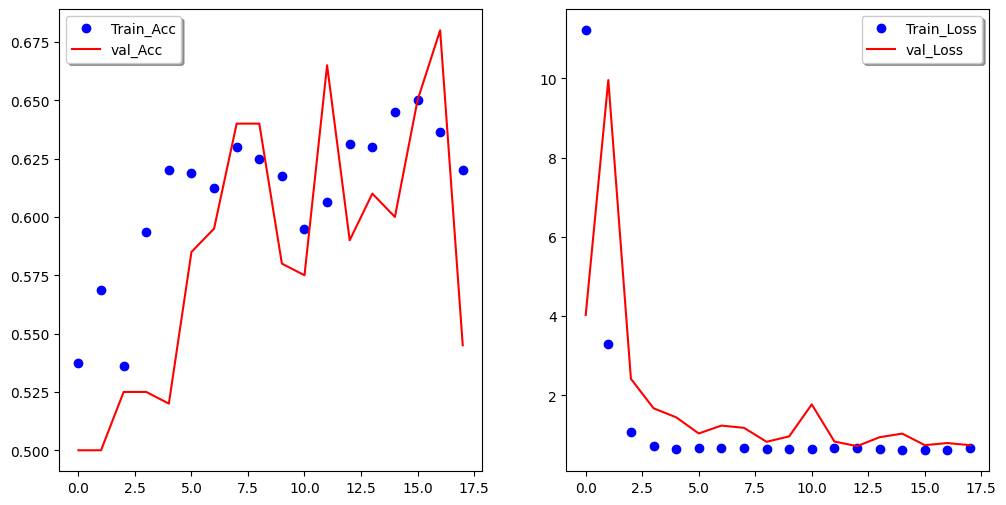

In [120]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(accuracy))

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(epochs, accuracy, 'bo', label="Train_Acc")
plt.plot(epochs, val_accuracy, 'r', label="val_Acc")
plt.legend(loc='best', shadow=True)

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'bo', label="Train_Loss")
plt.plot(epochs, val_loss, 'r', label="val_Loss")
plt.legend(loc='best', shadow=True)

plt.show()

> # The Epochs = 10 Only. We Can Increase The number of Epochs to Reach Suitable Accuracy.

> # Prepare Testing Data

In [121]:
# test_file_names = os.listdir("/kaggle/working/test1")
test_file_path = os.path.join(images_path,"test")

test_file_names = os.listdir(test_file_path)

test_df = pd.DataFrame({'image_path': test_file_names})

total_testing = test_df.shape[0]
print(test_df)

      image_path
0   cat.4033.jpg
1   cat.4034.jpg
2   cat.4035.jpg
3   cat.4036.jpg
4   cat.4037.jpg
5   cat.4038.jpg
6   cat.4039.jpg
7   cat.4040.jpg
8   cat.4041.jpg
9   cat.4042.jpg
10  dog.4023.jpg
11  dog.4024.jpg
12  dog.4025.jpg
13  dog.4026.jpg
14  dog.4027.jpg
15  dog.4028.jpg
16  dog.4029.jpg
17  dog.4030.jpg
18  dog.4031.jpg
19  dog.4032.jpg


> # Test The Model

> # Create Testing Generator

In [122]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    test_df, 
    directory=test_file_path,  # Assuming both 'cats' and 'dogs' are inside this directory
    x_col='image_path',  # Should contain paths like 'cats/image1.jpg' and 'dogs/image2.jpg'
    y_col=None,
    target_size=IMAGE_SIZE,
    class_mode=None,
    batch_size=batch_size,
    shuffle=False
)

Found 20 validated image filenames.


> # Predict

In [123]:
predictions = model.predict(test_generator)
print(predictions) # 1st col is prob for class 0, 2nd is class 1 

c:\Users\hi\Desktop\projects\python_projects\tutorial\tut_tensorflow\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
[[0.8404808  0.15951915]
 [0.66146094 0.33853906]
 [0.84251803 0.15748204]
 [0.6502783  0.34972173]
 [0.61437756 0.38562247]
 [0.81066704 0.18933296]
 [0.6526907  0.34730935]
 [0.85208094 0.14791904]
 [0.7891303  0.21086976]
 [0.63808906 0.3619109 ]
 [0.6021002  0.3978998 ]
 [0.51265603 0.48734394]
 [0.24401358 0.7559864 ]
 [0.59260887 0.40739113]
 [0.6492512  0.3507488 ]
 [0.79469943 0.20530054]
 [0.7617907  0.23820932]
 [0.61188555 0.38811445]
 [0.6783808  0.32161918]
 [0.6909292  0.3090708 ]]


> For categoral classication the prediction will come with probability of each category. So we will pick the category that have the highest probability with numpy average max

In [124]:
test_df["predicted_category"] = np.argmax(predictions, axis=1)
print(test_df)

      image_path  predicted_category
0   cat.4033.jpg                   0
1   cat.4034.jpg                   0
2   cat.4035.jpg                   0
3   cat.4036.jpg                   0
4   cat.4037.jpg                   0
5   cat.4038.jpg                   0
6   cat.4039.jpg                   0
7   cat.4040.jpg                   0
8   cat.4041.jpg                   0
9   cat.4042.jpg                   0
10  dog.4023.jpg                   0
11  dog.4024.jpg                   0
12  dog.4025.jpg                   1
13  dog.4026.jpg                   0
14  dog.4027.jpg                   0
15  dog.4028.jpg                   0
16  dog.4029.jpg                   0
17  dog.4030.jpg                   0
18  dog.4031.jpg                   0
19  dog.4032.jpg                   0


> We will convert the predict category back into our generator classes by using train_generator.class_indices. It is the classes that image generator map while converting data into computer vision

In [125]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['predicted_category'] = test_df['predicted_category'].replace(label_map)
print(test_df)

      image_path predicted_category
0   cat.4033.jpg                cat
1   cat.4034.jpg                cat
2   cat.4035.jpg                cat
3   cat.4036.jpg                cat
4   cat.4037.jpg                cat
5   cat.4038.jpg                cat
6   cat.4039.jpg                cat
7   cat.4040.jpg                cat
8   cat.4041.jpg                cat
9   cat.4042.jpg                cat
10  dog.4023.jpg                cat
11  dog.4024.jpg                cat
12  dog.4025.jpg                dog
13  dog.4026.jpg                cat
14  dog.4027.jpg                cat
15  dog.4028.jpg                cat
16  dog.4029.jpg                cat
17  dog.4030.jpg                cat
18  dog.4031.jpg                cat
19  dog.4032.jpg                cat


> From our prepare data part. We map data with {1: 'dog', 0: 'cat'}. Now we will map the result back to dog is 1 and cat is 0



In [126]:
test_df['predicted_category'] = test_df['predicted_category'].replace({ 'dog': 1, 'cat': 0 })
print(test_df)

      image_path  predicted_category
0   cat.4033.jpg                   0
1   cat.4034.jpg                   0
2   cat.4035.jpg                   0
3   cat.4036.jpg                   0
4   cat.4037.jpg                   0
5   cat.4038.jpg                   0
6   cat.4039.jpg                   0
7   cat.4040.jpg                   0
8   cat.4041.jpg                   0
9   cat.4042.jpg                   0
10  dog.4023.jpg                   0
11  dog.4024.jpg                   0
12  dog.4025.jpg                   1
13  dog.4026.jpg                   0
14  dog.4027.jpg                   0
15  dog.4028.jpg                   0
16  dog.4029.jpg                   0
17  dog.4030.jpg                   0
18  dog.4031.jpg                   0
19  dog.4032.jpg                   0


C:\Users\hi\AppData\Local\Temp\ipykernel_4100\2217309893.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df['predicted_category'] = test_df['predicted_category'].replace({ 'dog': 1, 'cat': 0 })


In [127]:
# Extract the category name
test_df['actual_category'] = test_df['image_path'].str.split('.').str[0]
test_df['actual_category'] = test_df['actual_category'].replace({ 'dog': 1, 'cat': 0 })

print(test_df)

      image_path  predicted_category  actual_category
0   cat.4033.jpg                   0                0
1   cat.4034.jpg                   0                0
2   cat.4035.jpg                   0                0
3   cat.4036.jpg                   0                0
4   cat.4037.jpg                   0                0
5   cat.4038.jpg                   0                0
6   cat.4039.jpg                   0                0
7   cat.4040.jpg                   0                0
8   cat.4041.jpg                   0                0
9   cat.4042.jpg                   0                0
10  dog.4023.jpg                   0                1
11  dog.4024.jpg                   0                1
12  dog.4025.jpg                   1                1
13  dog.4026.jpg                   0                1
14  dog.4027.jpg                   0                1
15  dog.4028.jpg                   0                1
16  dog.4029.jpg                   0                1
17  dog.4030.jpg            

C:\Users\hi\AppData\Local\Temp\ipykernel_4100\4255409534.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df['actual_category'] = test_df['actual_category'].replace({ 'dog': 1, 'cat': 0 })


# 6- Visualize The Result

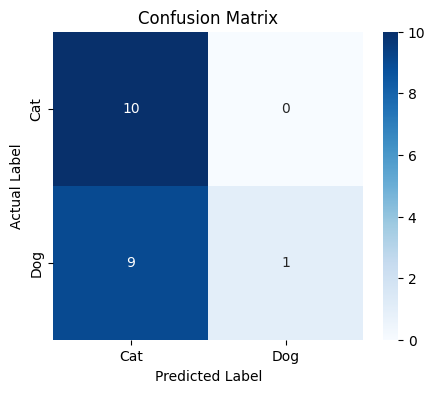

In [128]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Compute confusion matrix
cm = confusion_matrix(test_df['actual_category'], test_df['predicted_category'])

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

<Axes: xlabel='predicted_category'>

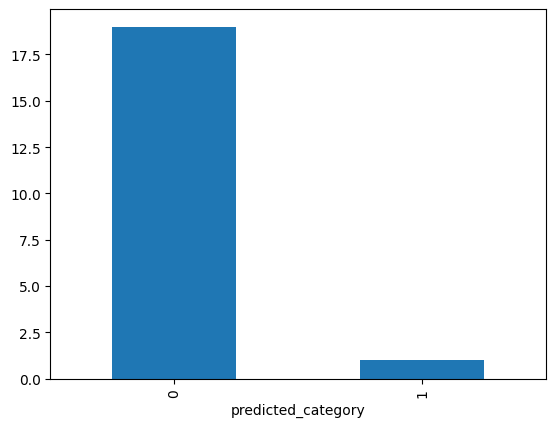

In [129]:
test_df["predicted_category"].value_counts().plot.bar()

> # Show Predicted Images

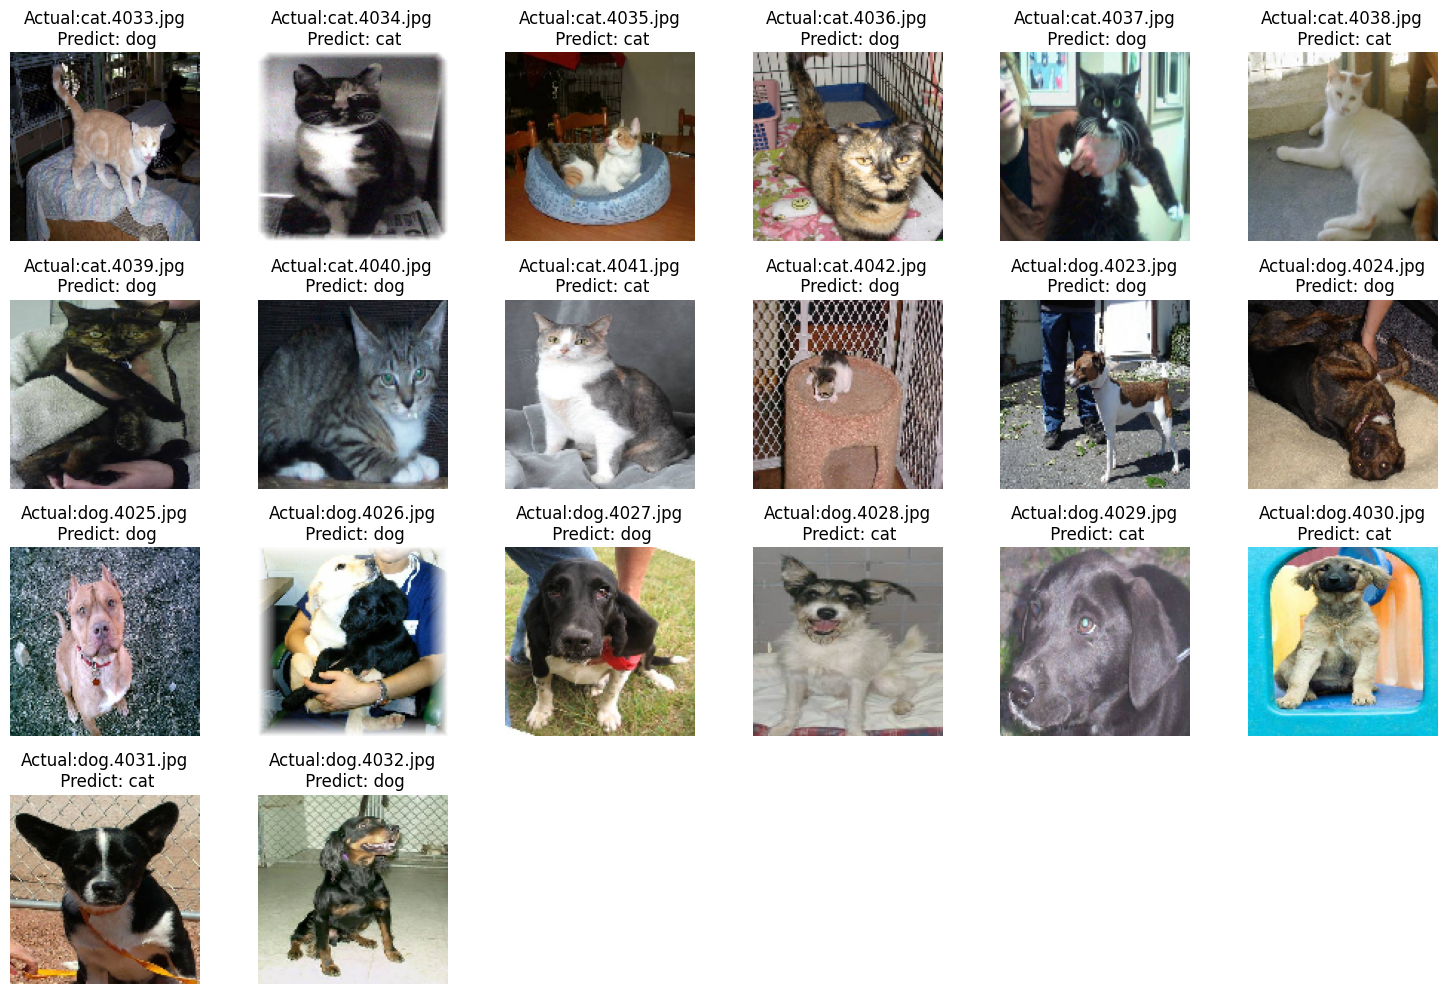

In [83]:
sample_test = test_df.head(36)

plt.figure(figsize=(15,15))

for index, row in sample_test.iterrows():
    file_name = row['image_path']
    pred_category = row['predicted_category']
    path = os.path.join("temp/test", file_name)
    img = load_img(path, target_size=IMAGE_SIZE)
    plt.subplot(6,6,index+1)
    plt.imshow(img)
    plt.title(f"Actual:{file_name}\n Predict: {'cat' if pred_category==0 else 'dog'}")
    plt.axis('off')
plt.tight_layout()
plt.show()